# 🧠 What is Query Planning and Decomposition?
Query Planning and Decomposition is a technique where a complex user query is broken down into simpler sub-questions or tasks, allowing a system (like a RAG agent) to:

- Understand the question more deeply
- Retrieve more precise and complete information
- Execute step-by-step reasoning

It's like reverse-engineering a question into manageable steps before answering.

🧠 What's New in This Version?
- ✅ Add a Query Planner Node
- ✅ Break complex user queries into sub-questions
- ✅ Retrieve docs per sub-question
- ✅ Combine all retrieved contexts
- ✅ Generate a final consolidated answer

## Setup and Import Libraries

In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader,WebBaseLoader
from langgraph.graph import StateGraph, END
from dotenv import load_dotenv

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
load_dotenv()

True

In [3]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [4]:
embeddings = OpenAIEmbeddings()
llm = init_chat_model("openai:gpt-4o")

## Document Loading and Creating Vector Database

In [5]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"
]

documents = []
for url in urls:
    documents.extend(WebBaseLoader(url).load())

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500, chunk_overlap=50
)

chunks = text_splitter.split_documents(documents=documents)

In [7]:
vector_store = FAISS.from_documents(
    documents=chunks, embedding=embeddings)

retriever = vector_store.as_retriever()

## State Schema

In [10]:
class RAGState(BaseModel):
    question: str
    sub_questions: List[str] = []
    retrieved_documents: List[Document] = []
    answer: str = ""

## Nodes

### Query Planner: splits input question

In [11]:
def plan_query(state: RAGState) -> RAGState:
   
    prompt = f"""
    Break the following complex question into 2-3 sub-questions:

    Question: {state.question}

    Sub-questions:
    """

    result = llm.invoke(prompt)
    sub_questions = [line.strip("- ").strip() for line in result.content.strip().split("\n") if line.strip()]
    
    return RAGState(question=state.question, sub_questions=sub_questions)

### Retrieve documents for each sub-question

In [12]:
def retrieve_for_each(state: RAGState) -> RAGState:
    documents = []
    for sub in state.sub_questions:
        document = retriever.invoke(sub)
        documents.extend(document)
        
    return RAGState(question=state.question, sub_questions=state.sub_questions, retrieved_documents=documents)

### Generate final answer

In [13]:
def generate_final_answer(state: RAGState) -> RAGState:
    context = "\n\n".join([document.page_content for document in state.retrieved_documents])

    prompt = f"""
    Use the context below to answer the question.

    Context:
    {context}

    Question: {state.question}
    """
    
    answer = llm.invoke(prompt).content

    return RAGState(question=state.question, sub_questions=state.sub_questions, retrieved_docs=state.retrieved_documents, answer=answer)

## Build Graph

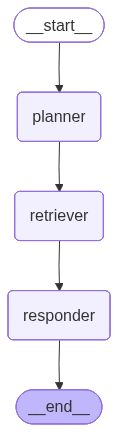

In [14]:
builder = StateGraph(RAGState)

# Add Nodes
builder.add_node(node="planner", action=plan_query)
builder.add_node(node="retriever", action=retrieve_for_each)
builder.add_node(node="responder", action=generate_final_answer)

# Set Entry Point
builder.set_entry_point(key="planner")

# Add Edges
builder.add_edge(start_key="planner", end_key="retriever")
builder.add_edge(start_key="retriever", end_key="responder")
builder.add_edge(start_key="responder", end_key=END)

# Compile Graph
graph = builder.compile()

# Display
graph

In [15]:
user_query = "Explain how agent loops work and what are the challenges in diffusion video generation?"

initial_state = RAGState(question=user_query)
final_state = graph.invoke(input=initial_state)
print(final_state)

print("\n🔍 Sub-questions:")
for q in final_state['sub_questions']:
    print("-", q)

print("\n✅ Final Answer:\n", final_state['answer'])

{'question': 'Explain how agent loops work and what are the challenges in diffusion video generation?', 'sub_questions': ['1. How do agent loops function, and what are their key components and mechanisms in general?', '2. What is the process of diffusion video generation, and how are agent loops utilized in this context?', '3. What specific challenges are encountered in the diffusion video generation process, particularly in relation to agent loops?'], 'retrieved_documents': [], 'answer': '**Agent Loops:**\n\nAgent loops refer to the processes that combine large language models (LLMs) with memory, planning, and reflection mechanisms. These loops allow agents to perform tasks based on past experiences and interactions with other agents. For LLM-centered agents, agent loops typically involve:\n\n1. **Task Decomposition**: Breaking down a complex task into smaller, manageable steps that an agent can execute sequentially or in parallel.\n2. **Memory Integration**: Using past interactions a